In [1]:
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, Polygon

In [2]:
!curl 'https://rigma-web.collectivitedemartinique.mq/ags2/rest/services/METIER/res_rou_compteur_routier_972/FeatureServer/1/query?f=json&where=1%3D1&returnGeometry=true&spatialRel=esriSpatialRelIntersects&outFields=*&orderByFields=objectid%20ASC&resultOffset=0&resultRecordCount=1000' \
    -o data-tmp/compteur-route-1.json    

!curl 'https://rigma-web.collectivitedemartinique.mq/ags2/rest/services/METIER/res_rou_compteur_routier_972/FeatureServer/2/query?f=json&where=1%3D1&returnGeometry=true&spatialRel=esriSpatialRelIntersects&outFields=*&orderByFields=objectid%20ASC&resultOffset=0&resultRecordCount=1000' \
    -o data-tmp/compteur-route-2.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  151k    0  151k    0     0  34207      0 --:--:--  0:00:04 --:--:-- 38188
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87692    0 87692    0     0   220k      0 --:--:-- --:--:-- --:--:--  221k


In [3]:
compteurs = []

def read_data(file, arr):
    with open(file) as r:
        data = json.load(r)

    for f in data['features']:
        x = f['attributes']
        lon, lat = None, None
        if x and 'xy' in x and x['xy'] and x['xy'].strip() != '':
            lat, lon = [float(v) for v in x['xy'].split(', ')]
        traffic = None
        if 'trafic_moy' in x and x['trafic_moy'] and x['trafic_moy'].strip() != '':
            traffic = float(x['trafic_moy'].strip().replace(' ', '').replace(',', '.'))
        arr.append([x['descriptio'], x['etat_compt'], x['fixe___tem'], x['configurat'], traffic, lon, lat])

read_data('data-tmp/compteur-route-1.json', compteurs)
read_data('data-tmp/compteur-route-2.json', compteurs)

df = pd.DataFrame(data=compteurs, columns=['description', 'etat', 'duration', 'conf', 'traffic', 'lon', 'lat'])

In [4]:
z = df.dropna(subset = ['lat', 'lon', 'traffic']).copy()
z['geometry'] = z[['lat', 'lon']].apply(lambda x: Point(x[1], x[0]), axis=1)

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


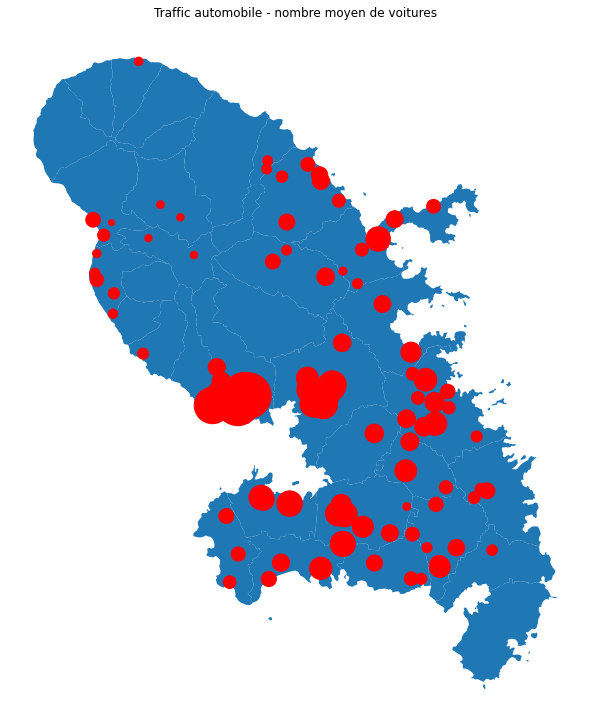

In [5]:
COMMUNES_FILES = 'data/communes-martinique.geojson'
communes = gpd.read_file(COMMUNES_FILES)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle("Traffic automobile - nombre moyen de voitures (données CTM)")

communes.plot(ax=ax)

gdf = gpd.GeoDataFrame(z)
gdf = gdf.set_crs(4326, allow_override=True)
gdf.plot(ax=ax, markersize=gdf['traffic']**0.666, color="red")

_ = ax.axis('off')
fig.savefig('output/2022-11-23.png', facecolor='white')